In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import seaborn as sns

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess
import postprocessing

# sns.set_theme('notebook', font_scale=1.0)
# sns.set_style('whitegrid')

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
n_neurons = 10
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.5 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.2 #! changed from 0.1

In [3]:
@partial(jax.vmap, in_axes=(0, 0))
def dynamics(theta, omega):
    u = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    v = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    A = (1 - epsilon) * v[:, None] * v[None, :]
    b = u #+ omega * v
    z = jnp.clip(theta - peaks, -jnp.pi * widths, jnp.pi * widths)
    C = (1 + jnp.cos(z / widths))[:, None] * (
        jnp.tile(u[None, :], (n_neurons, 1))
    )
    return (A, b, C)

def initial_condition(theta, omega):
    m0 = jnp.array([jnp.cos(theta), jnp.sin(theta)]) # Change to 0 if needed for composite dynamics
    S0 = noise_scale * jnp.eye(2)
    return (m0, S0)

def run_dynamics(key, As, bs, Cs, m0, S0):

    def f(x, inp):
        A, b, C, (subkey1, subkey2) = inp
        emission_noise = noise_scale * (
            jxr.multivariate_normal(subkey2, jnp.zeros(n_neurons), jnp.eye(n_neurons))
        )
        y = C @ x + emission_noise

        dynamics_noise = noise_scale * (
            jxr.multivariate_normal(subkey1, jnp.zeros(2), jnp.eye(2))
        )
        x_next = A @ x + b + dynamics_noise
        return x_next, (x_next, y)

    x_init = jxr.multivariate_normal(key, m0, S0)
    subkeys = jxr.split(key, num=(As.shape[0],2))
    _, (x_nexts, ys) = jax.lax.scan(f, x_init, xs=(As, bs, Cs, subkeys))
    # print(x_init)
    # print(x_nexts[0])
    xs = jnp.concatenate([x_init[None, :], x_nexts[:-1]], axis=0)
    return xs, ys

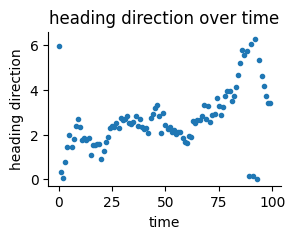

In [4]:
# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
B = 100

# Thetas as a random walk 

key = jxr.PRNGKey(1)
thetas = []
for i in range(B):
    key, subkey = jxr.split(key)
    theta = jnp.cumsum(0.4 * jxr.normal(subkey, shape=(num_timesteps,)))
    thetas.append(theta)

theta = jnp.stack(thetas, axis=0)

# # Theta as cumulative sum of omega, tiled

# theta = jnp.tile(jnp.cumsum(omega), (B, 1))

# Plot heading direction trajectory
plt.figure(figsize=[3,2])
plt.plot(theta[0] % (2 * jnp.pi), '.')
# plt.plot(theta[1] % (2 * jnp.pi), '.')
plt.ylabel('heading direction')
plt.xlabel('time')
plt.title('heading direction over time');
sns.despine()
# plt.savefig('figures/HD_heading_direction_conditions.eps')

In [5]:
# Generate time-varying linear dynamics and initial condition to get a batch of data

true_C = jxr.normal(jxr.PRNGKey(0), (n_neurons, 2)) # Overwrites neuron tuning
true_Cs = jnp.tile(true_C, (num_timesteps, 1, 1))


def form_batch(i):
    true_As, true_bs, _ = dynamics(theta[i], omega)
    true_m0, true_S0 = initial_condition(theta[i,0], omega[0])

    key = jxr.PRNGKey(i)
    x, y = run_dynamics(key, true_As, true_bs, true_Cs, true_m0, true_S0)
    return x, y

X, Y = jax.vmap(form_batch)(jnp.arange(B))

X = jnp.stack(X, axis=0)
Y = jnp.stack(Y, axis=0)

partition = int(0.8 * B)
X_train, Y_train = X[:partition], Y[:partition]
X_test, Y_test = X[partition:], Y[partition:]

thetas_train = theta[:partition]
thetas_test = theta[partition:]

# # Plot
# fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
# axs[0].plot(true_As[:,1]);
# axs[1].plot(true_bs);
# axs[2].plot(theta[0] % (2 * jnp.pi), true_Cs[:,:,0], '-');
# axs[0].set_title("A")
# axs[1].set_title("b")
# axs[2].set_title("C")
# fig.suptitle("True params")

Text(0.5, 0.98, 'True As')

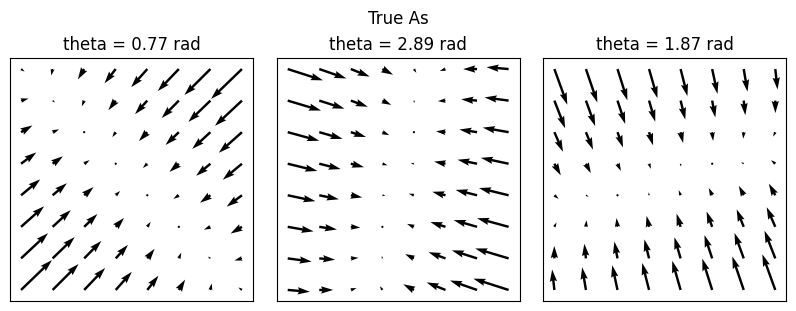

In [6]:
def plot_vector_field(A, ax):
    x = jnp.linspace(-1, 1, 8)
    y = jnp.linspace(-1, 1, 8)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=8, width=0.01)

theta_indices = [3, 76, 58]

fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
for i, _theta_ind in enumerate(theta_indices):
    _theta = theta[0][_theta_ind]
    true_As = dynamics(theta[0], omega)[0]
    plot_vector_field(true_As[_theta_ind] - jnp.eye(2), axs[i])
    axs[i].set_title(f"theta = {_theta % (2*jnp.pi):.2f} rad")

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("True As")
# plt.savefig("figures/demo_HD_vector_field.eps", format='eps')

Text(0.5, 0.98, 'A prior samples')

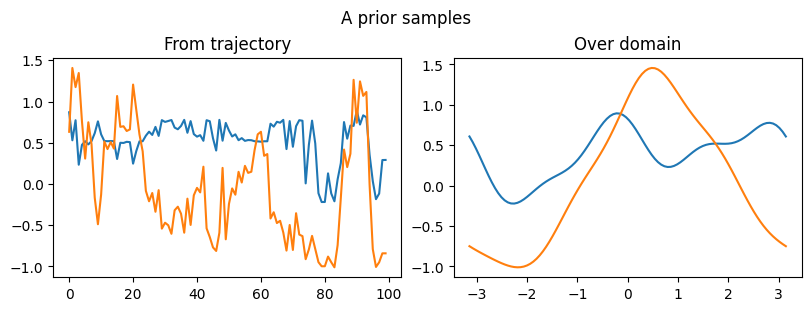

In [7]:
# Define model

_sigma, _kappa, _period = 0.5, 0.1, 2*jnp.pi
torus_basis_funcs = utils.T1_basis(5, _sigma, _kappa, _period)

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
m0_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
C_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=n_neurons, D2=latent_dim)
model = wGPLDS(
    wgps={
        'A': A_prior, 
        'b': b_prior,
        'C': None,
        'm0': m0_prior,
        }, 
    state_dim=latent_dim, 
    emission_dim=n_neurons,
    )

fig, (ax, ax2) = plt.subplots(figsize=[8,3], ncols=2, constrained_layout=True)
ax.plot(A_prior.sample(jxr.PRNGKey(0), theta[0])[:,0,0]);
ax.plot(A_prior.sample(jxr.PRNGKey(0), theta[0])[:,0,1]);
ax.set_title('From trajectory');
ax2.plot(jnp.linspace(-jnp.pi, jnp.pi, 100), A_prior.sample(jxr.PRNGKey(0), jnp.linspace(-jnp.pi, jnp.pi, 100))[:,0,0]);
ax2.plot(jnp.linspace(-jnp.pi, jnp.pi, 100), A_prior.sample(jxr.PRNGKey(0), jnp.linspace(-jnp.pi, jnp.pi, 100))[:,0,1]);
ax2.set_title('Over domain');
fig.suptitle('A prior samples')

# Fitting

Iter 1/200, log-prob = -181980.08, marginal log-lik = -175764.70
Iter 2/200, log-prob = -32020.03, marginal log-lik = -30831.63
Iter 3/200, log-prob = -25047.64, marginal log-lik = -23722.32
Iter 4/200, log-prob = -20367.61, marginal log-lik = -19365.70
Iter 5/200, log-prob = -17506.41, marginal log-lik = -16311.56
Iter 6/200, log-prob = -15496.44, marginal log-lik = -14352.23
Iter 7/200, log-prob = -14273.81, marginal log-lik = -13008.58
Iter 8/200, log-prob = -13334.00, marginal log-lik = -12115.34
Iter 9/200, log-prob = -12797.04, marginal log-lik = -11529.84
Iter 10/200, log-prob = -12339.99, marginal log-lik = -11121.05
Iter 11/200, log-prob = -12070.24, marginal log-lik = -10830.25
Iter 12/200, log-prob = -11798.49, marginal log-lik = -10591.98
Iter 13/200, log-prob = -11621.97, marginal log-lik = -10400.90
Iter 14/200, log-prob = -11427.91, marginal log-lik = -10225.36
Iter 15/200, log-prob = -11292.08, marginal log-lik = -10075.28
Iter 16/200, log-prob = -11142.41, marginal log

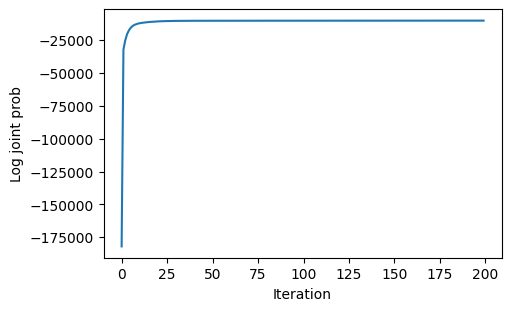

In [8]:
from models import ParamswGPLDS

seed = 1
A_key, b_key, C_key, m0_key = jxr.split(jxr.PRNGKey(seed), 4)

conditions = theta[0]

initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.sample_weights(A_key),
    m0_gp_weights = m0_prior.sample_weights(m0_key),
    emissions_gp_weights = None,#C_prior.sample_weights(C_key),
    bias_gp_weights = b_prior.sample_weights(b_key),
    Q = jnp.eye(latent_dim),
    R = jnp.eye(n_neurons),
    m0 = None,
    S0 = jnp.eye(latent_dim),
    Cs = jnp.tile(jxr.normal(C_key, (n_neurons, 2)), (num_timesteps, 1, 1)),
    bs = None,# b_prior.sample(b_key, conditions).squeeze(),
)

params, log_probs = model.fit_em(initial_params, emissions=Y_train, conditions=thetas_train, num_iters=200)

if params.bs is None:
    params = params._replace(bs = b_prior(params.bias_gp_weights, conditions).squeeze())
if params.Cs is None:
    params = params._replace(Cs = C_prior(params.emissions_gp_weights, conditions))
if params.Cs.ndim == 2:
    params = params._replace(Cs=jnp.tile(params.Cs[None, :, :], (num_timesteps, 1, 1)))

fig, ax = plt.subplots(figsize=[5,3], constrained_layout=True)
ax.plot(log_probs)
ax.set_ylabel('Log joint prob')
ax.set_xlabel('Iteration');

# Show recovery

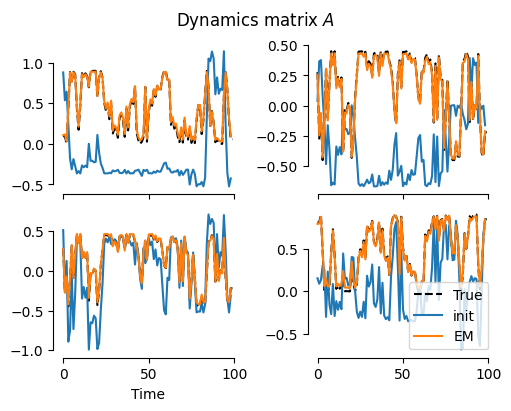

In [9]:
fig, axs = plt.subplots(ncols=latent_dim, nrows=latent_dim, figsize=(5, 4), constrained_layout=True);

for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        true_As, true_bs, true_Cs = dynamics(theta[0], omega)
        ax.plot(true_As[:,i,j], 'k--', label='True')
        ax.plot(A_prior(initial_params.dynamics_gp_weights, theta[0][:-1])[:,i,j], label='init')
        ax.plot(A_prior(params.dynamics_gp_weights, theta[0][:-1])[:,i,j], label='EM')
        # ax.set_title(f'A[{i},{j}]')
axs[1,0].set_xlabel('Time')
axs[1,1].legend()

for ax in axs.flatten():
    sns.despine(ax=ax, trim=True, offset=True)
for ax in axs[0]:
    ax.set_xticklabels([])
    
fig.suptitle('Dynamics matrix $A$');

Text(0.5, 0, 'Time')

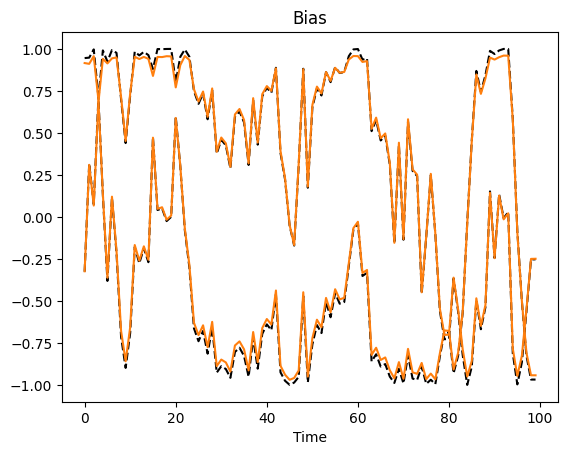

In [10]:
fig, ax = plt.subplots()
ax.plot(dynamics(theta[0], omega)[1],'k--', label='True');
ax.plot(b_prior(params.bias_gp_weights, theta[0]).squeeze(), c='tab:orange', label='EM');
ax.set_title("Bias")
ax.set_xlabel('Time')

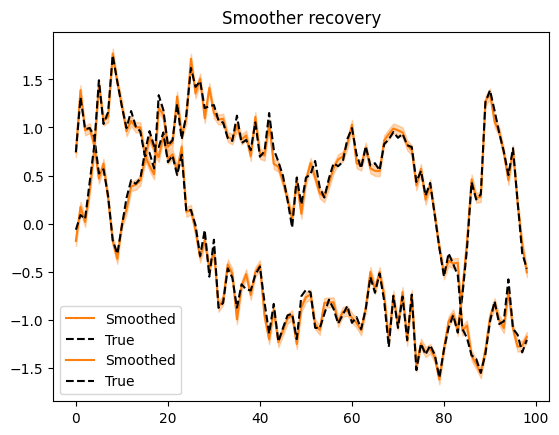

In [11]:
batch_id = 0
_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    params, 
    emissions = Y_train[batch_id],
    inputs = theta[batch_id],
)

fig, ax = plt.subplots()
for i in range(2):
    ax.plot(smoothed_means[1:, i], color='tab:orange', label='Smoothed')
    ax.fill_between(
        jnp.arange(num_timesteps - 1),
        smoothed_means[1:, i] - 2 * jnp.sqrt(smoothed_covs[1:, i, i]),
        smoothed_means[1:, i] + 2 * jnp.sqrt(smoothed_covs[1:, i, i]),
        color='tab:orange',
        alpha=0.3,
    )
    ax.plot(X_train[batch_id, 1:, i], 'k--', label='True')
ax.set_title('Smoother recovery')
ax.legend();

Text(0.5, 0, 'Time')

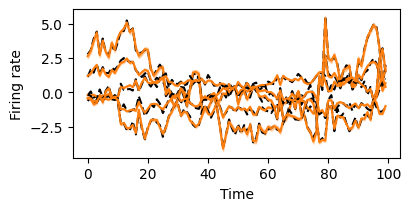

In [12]:
# if params.Cs.ndim == 2:
#     params = params._replace(Cs = jnp.tile(params.Cs[None, :], (num_timesteps, 1, 1)))

_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    params, 
    emissions = Y_test[0],
    inputs = thetas_test[0],
)

reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

fig, ax = plt.subplots(figsize=[4,2], constrained_layout=True);
for neuron_id in range(n_neurons)[::2]:
    ax.plot(Y_test[0][:100,neuron_id] , c='k', ls='--');
    ax.plot(reconstructed_ys[:100,neuron_id], c='tab:orange');
    ax.fill_between(
        jnp.arange(len(reconstructed_ys))[:100],
        reconstructed_ys[:100,neuron_id] - 2 * jnp.sqrt(reconstructed_ys_covs[:100,neuron_id,neuron_id]),
        reconstructed_ys[:100,neuron_id] + 2 * jnp.sqrt(reconstructed_ys_covs[:100,neuron_id,neuron_id]),
        alpha=0.3, color='tab:orange',
    )
ax.set_ylabel('Firing rate')
ax.set_xlabel('Time')
# plt.legend()
# ax.set_title('Reconstructed data, half the neurons');
# plt.savefig('figures/HD_reconstructed_data.eps')

(100, 10, 2) (100, 2)


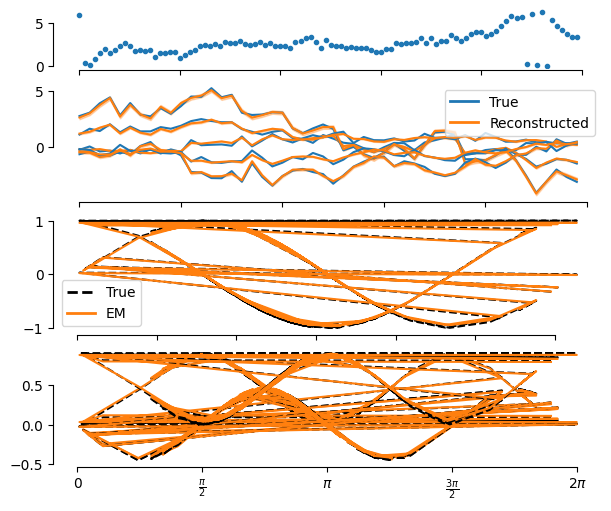

In [13]:
fig, axs = plt.subplots(nrows=4, figsize=(6, 5), height_ratios=[1,2,2,2], constrained_layout=True);

axs[0].plot(theta[0] % (2 * jnp.pi), '.', c='tab:blue');

# Reconstruction

_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    params, 
    emissions = Y_test[0],
    inputs = theta[0],
)
print(params.Cs.shape, smoothed_means.shape)
reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

for neuron_id in range(n_neurons)[::2]:
    axs[1].plot(Y_test[0][:50,neuron_id], c='tab:blue');
    axs[1].plot(reconstructed_ys[:50,neuron_id], c='tab:orange');
    axs[1].fill_between(
        jnp.arange(len(reconstructed_ys))[:50],
        reconstructed_ys[:50,neuron_id] - 2 * jnp.sqrt(reconstructed_ys_covs[:50,neuron_id,neuron_id]),
        reconstructed_ys[:50,neuron_id] + 2 * jnp.sqrt(reconstructed_ys_covs[:50,neuron_id,neuron_id]),
        alpha=0.3, color='tab:orange',
    )

lines = [plt.Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in ['tab:blue', 'tab:orange']]
labels = ['True', 'Reconstructed']
axs[1].legend(lines, labels)

# Bias 

true_bs = dynamics(theta[0], omega)[1]
axs[2].plot(theta[0] % (2*jnp.pi), true_bs,'k--', label='True');
axs[2].plot(theta[0] % (2*jnp.pi), params.bs, c='tab:orange', label='EM');
# axs[1].set_title("Bias")
# axs[1].set_xlabel('Time')

# Dynamics

for i in range(2):
    for j in range(2):
        axs[3].plot(theta[0] % (2*jnp.pi), true_As[:,i,j], 'k--', label='True')
        # axs[3].plot(A_prior(initial_params.dynamics_gp_weights, theta[:-1])[:,i,j], label='init')
        axs[3].plot(theta[0][:-1] % (2*jnp.pi), A_prior(params.dynamics_gp_weights, theta[0][:-1])[:,i,j], c='tab:orange', label='EM')
        # ax.set_title(f'A[{i},{j}]')

# Labels and formatting

for ax in axs[:-1]:
    ax.set_xticklabels([])
axs[-1].set_xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi])
axs[-1].set_xticklabels(['0', r"$\frac{\pi}{2}$", '$\pi$', r"$\frac{3\pi}{2}$", '$2\pi$'])
for ax in axs.flatten():
    sns.despine(ax=ax, trim=True, offset=True)
# for ax in axs[0]:
#     ax.set_xticklabels([])


lines = [plt.Line2D([0], [0], color='k', linewidth=2, linestyle='--'), plt.Line2D([0], [0], color='tab:orange', linewidth=2, linestyle='-')]
labels = ['True', 'EM']
axs[2].legend(lines, labels)

# plt.savefig("figures/demo_HD_EM_recovery.eps", format='eps')

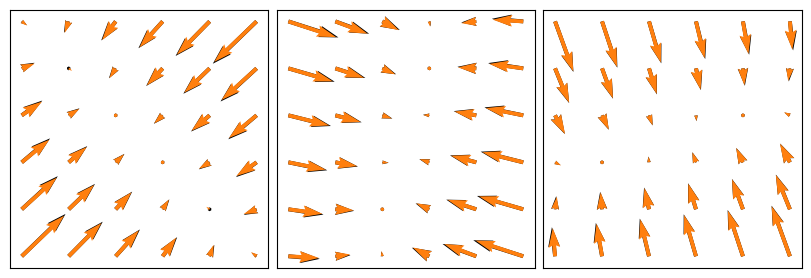

In [14]:
# Plot vector field given 2x2 matrix

def plot_vector_field(A, ax, color='k'):
    x = jnp.linspace(-1, 1, 6)
    y = jnp.linspace(-1, 1, 6)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=6, width=0.015, color=color)

_As = A_prior(params.dynamics_gp_weights, theta[0][:-1])
true_As = dynamics(theta[0], omega)[0]

fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
plot_vector_field(true_As[3] - jnp.eye(latent_dim), axs[0])
plot_vector_field(_As[3] - jnp.eye(latent_dim), axs[0], color='tab:orange')

plot_vector_field(true_As[76] - jnp.eye(latent_dim), axs[1])
plot_vector_field(_As[76] - jnp.eye(latent_dim), axs[1], color='tab:orange')

plot_vector_field(true_As[58] - jnp.eye(latent_dim), axs[2])
plot_vector_field(_As[58] - jnp.eye(latent_dim), axs[2], color='tab:orange')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

# plt.savefig("figures/demo_HD_vector_field_recovery.eps", format='eps')

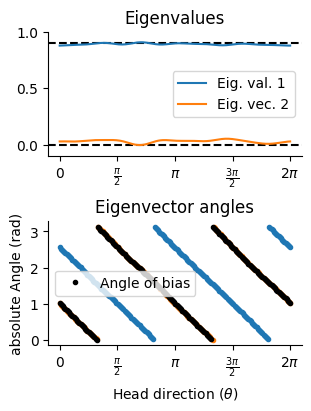

In [15]:
theta_range = jnp.linspace(0, 2*jnp.pi, 200)
bs_theta = b_prior(params.bias_gp_weights, theta_range).squeeze()
As_theta = A_prior(params.dynamics_gp_weights, theta_range)

def get_angles(vs, correction=0):
    angles = jnp.arctan2(vs[:,1], vs[:,0]) + correction
    return jnp.where(angles < 0, angles + 2*jnp.pi, angles)

# Rotate first

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T
Hinv = _U @ jnp.diag(jnp.sqrt(_S))

bs_theta_rot = jnp.einsum('ij,tj->ti', H, bs_theta)
As_theta_rot = jnp.einsum('ij,tjk,kl->til', H, As_theta, Hinv)

# Calculate eigenvalues and eigenvectors angles

eigvals, eigvecs = jnp.linalg.eig(As_theta_rot)
true_eigvals, true_eigvecs = jnp.linalg.eig(true_As)

top_eigenval = jnp.where(eigvals.real[:,0] > eigvals.real[:,1], eigvals.real[:,0], eigvals.real[:,1])
bottom_eigenval = jnp.where(eigvals.real[:,0] < eigvals.real[:,1], eigvals.real[:,0], eigvals.real[:,1])

angles_1 = get_angles(eigvecs[:,:,0].real)
angles_2 = get_angles(eigvecs[:,:,1].real)

top_eigvec_angles = jnp.where(top_eigenval == eigvals.real[:,0], angles_1, angles_2)
bottom_eigvec_angles = jnp.where(bottom_eigenval == eigvals.real[:,0], angles_1, angles_2) 

# Plot

fig, axs = plt.subplots(figsize=[3,4], nrows=2, constrained_layout=True)
axs[0].plot(theta_range, top_eigenval, label='Eig. val. 1')
axs[0].plot(theta_range, bottom_eigenval, label='Eig. vec. 2')
axs[0].axhline(1-epsilon, c='k', ls='--', zorder=-1)
axs[0].axhline(0., c='k', ls='--', zorder=-1)
axs[0].set_ylim([-0.1,1.])
axs[0].legend()
axs[0].set_title('Eigenvalues')

axs[1].plot(theta_range, top_eigvec_angles  % jnp.pi, '.', c='tab:blue')
axs[1].plot(theta_range, bottom_eigvec_angles  % jnp.pi, '.', c='tab:orange')
axs[1].set_title('Eigenvector angles')
axs[1].set_ylabel('absolute Angle (rad)')
b_theta_angles = get_angles(bs_theta_rot)
b_theta_angles = jnp.where(b_theta_angles < 0, b_theta_angles + 2*jnp.pi, b_theta_angles) # Correct for negative angles

axs[1].plot(theta_range, b_theta_angles % jnp.pi, '.', c='k', label='Angle of bias')
axs[1].legend()
axs[1].set_xlabel(r'Head direction ($\theta$)')

for ax in axs:
    sns.despine(ax=ax)
    ax.set_xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi])
    ax.set_xticklabels(['0', r"$\frac{\pi}{2}$", '$\pi$', r"$\frac{3\pi}{2}$", '$2\pi$'])
# plt.savefig("figures/demo_HD_eigenvalues_angles.eps", format='eps')

# Postprocessing analysis

Fixed points and composite dynamics

In [16]:
# Rotate latents to have identity Q, and calculate fixed points 

theta_range = jnp.linspace(0, 2*jnp.pi, 100)
fixed_points = postprocessing.get_fixed_points(model, params, theta_range, ROTATE=True)

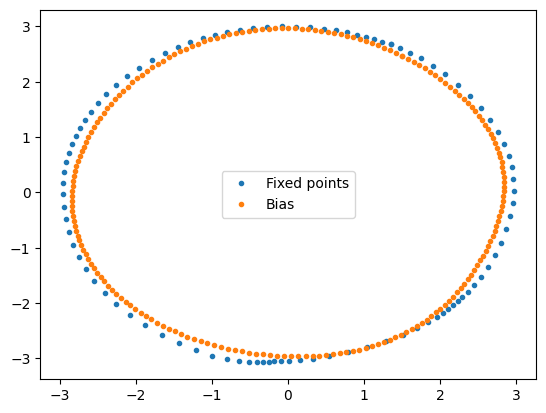

In [17]:
plt.plot(*fixed_points.T, '.', label='Fixed points')
plt.plot(*bs_theta_rot.T, '.', label='Bias')
plt.legend();

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-pack

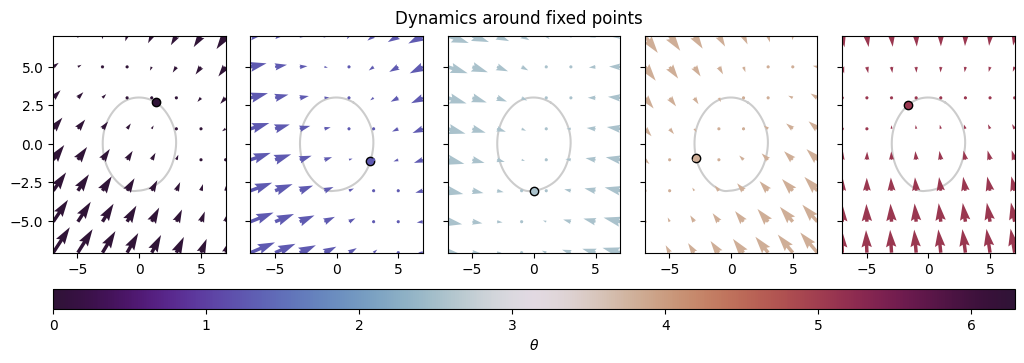

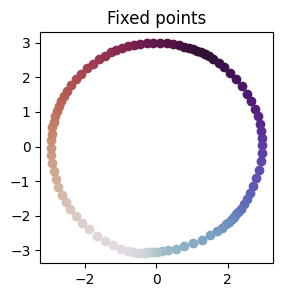

In [18]:
# Plot vector fields per fixed point

cmap = plt.cm.twilight_shifted
colors = cmap(theta_range/(2*jnp.pi))

# =============================================================================

x_lims = (jnp.amin(fixed_points[:,0])-4, jnp.amax(fixed_points[:,0])+4)
y_lims = (jnp.amin(fixed_points[:,1])-4, jnp.amax(fixed_points[:,1])+4)

def plot_vector_field(A, ax, center=jnp.zeros((2,)), color='k'):
    x = jnp.linspace(*x_lims, 8)
    y = jnp.linspace(*y_lims, 8)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * (X - center[0]) + A[0, 1] * (Y - center[1])
    V = A[1, 0] * (X - center[0]) + A[1, 1] * (Y - center[1])

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=70, width=0.02, color=color)

# sns.set_style('white')
fig = plt.figure(figsize=[10,3.5], constrained_layout=True)

ncols = 5
gs = fig.add_gridspec(1, ncols, wspace=0.1)
axs = [fig.add_subplot(gs[0, i]) for i in range(ncols)]

indices = jnp.linspace(0, len(fixed_points), len(axs), endpoint=False, dtype=int)
for i, ax in zip(indices, axs):
    ax.scatter(*fixed_points[i], color=colors[i], edgecolors='k')
    ax.plot(*fixed_points.T, c='k', alpha=0.2, zorder=-1)
    plot_vector_field(As_theta_rot[i] - jnp.eye(2), ax=ax, center=fixed_points[i], color=colors[i])

for ax in axs:
    if ax is not axs[0]:
        ax.set_yticklabels([])
    ax.set_xlim(*x_lims)
    ax.set_ylim(*y_lims)

# Add colorbar
norm = plt.Normalize(0, 2*jnp.pi)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs, orientation='horizontal', label=r'$\theta$', aspect=50) # shrink=1.0

fig.suptitle('Dynamics around fixed points')
plt.show()

# =============================================================================

fig, ax = plt.subplots(figsize=[3,3])
for i, fp in enumerate(fixed_points):
    ax.scatter(*fp, color=colors[i])
ax.set_title('Fixed points')
plt.show()

## Composite dynamics

In [19]:
# from scipy.stats import binned_statistic_2d
# from tqdm import tqdm

# x_lims = (jnp.amin(fixed_points[:,0])-2, jnp.amax(fixed_points[:,0])+2)
# y_lims = (jnp.amin(fixed_points[:,1])-2, jnp.amax(fixed_points[:,1])+2)

# x_bin_edges = jnp.linspace(*x_lims, 22)
# y_bin_edges = jnp.linspace(*y_lims, 20)

# xy_meshgrid = jnp.meshgrid(x_bin_edges, y_bin_edges)
# xy_meshgrid = jnp.stack([xy_meshgrid[0].ravel(), xy_meshgrid[1].ravel()]).T


# def get_statistic_per_bin(values, xs, statistic='sum'):
#     statistics, _, _, _ = binned_statistic_2d(
#         xs[:,0], xs[:,1], values,
#         bins=[x_bin_edges, y_bin_edges], statistic=statistic
#         )
#     return statistics

# def get_values_per_bin(parameters, xs):
#     D1, D2 = parameters.shape[1], parameters.shape[2]
#     parameters_sum_per_bin = get_statistic_per_bin(
#         jnp.array([[parameters[:,i,j] for i in range(D1)] for j in range(D2)]).reshape(-1, len(xs)),
#         xs,
#     )
#     # As_sum, _, _, _ = binned_statistic_2d(
#     #     x_smooth_rot[:,0], x_smooth_rot[:,1], 
#     #     jnp.array([[parameters_rot[:,i,j] for j in range(D1)] for i in range(D2)]).reshape(-1, len(x_smooth)),
#     #     bins=[x_bin_edges, y_bin_edges], statistic='sum'
#     #     )
#     parameters_sum_per_bin = parameters_sum_per_bin.reshape(D1, D2, len(x_bin_edges)-1, len(y_bin_edges)-1) 
#     return parameters_sum_per_bin


# As_bin_sums, bs_bin_sums, thetas_bin_sums, bin_counts = [], [], [], []
# for batch_id in tqdm(range(len(Y_train))):
#     # Compute posterior x
#     x_smooth = model.smoother(params, Y_train[batch_id], thetas_train[batch_id])[2][0]
#     x_smooth_rot = jnp.einsum('ij,tj->ti', H, x_smooth)

#     # MAP estimates of As and bs
#     batch_As = A_prior(params.dynamics_gp_weights, thetas_train[batch_id])
#     batch_As_rot = jnp.einsum('ij,tjk,kl->til', H, batch_As, Hinv)

#     batch_bs = b_prior(params.bias_gp_weights, thetas_train[batch_id])
#     batch_bs_rot = jnp.einsum('ij,tjk->tik', H, batch_bs)

#     # Estimate parameters and statistics per bin
#     As_sums = get_values_per_bin(batch_As_rot, x_smooth_rot)
#     bs_sums = get_values_per_bin(batch_bs_rot, x_smooth_rot).squeeze()
    
#     # thetas_sums, _, _, _ = binned_statistic_2d(
#     #     x_smooth_rot[:,0], x_smooth_rot[:,1], thetas_train[batch_id],
#     #     bins=[x_bin_edges, y_bin_edges], statistic='sum'
#     #     )
#     thetas_sums = get_statistic_per_bin(thetas_train[batch_id], x_smooth_rot, statistic='sum')
    
#     # counts, _, _, _ = binned_statistic_2d(
#     #     x_smooth_rot[:,0], x_smooth_rot[:,1], thetas_train[batch_id],
#     #     bins=[x_bin_edges, y_bin_edges], statistic='count'
#     #     )
#     counts = get_statistic_per_bin(thetas_train[batch_id], x_smooth_rot, statistic='count')
    
#     As_bin_sums.append(As_sums)
#     bs_bin_sums.append(bs_sums)
#     thetas_bin_sums.append(thetas_sums)
#     bin_counts.append(counts)

# bin_counts = jnp.nansum(jnp.array(bin_counts), axis=0)

# As_bin_sums = jnp.nansum(jnp.array(As_bin_sums), axis=0)
# As_bin_means = As_bin_sums/bin_counts[None, None, ...]

# bs_bin_sums = jnp.nansum(jnp.array(bs_bin_sums), axis=0)
# print(bs_bin_sums.shape)
# bs_bin_means = bs_bin_sums/bin_counts[None, ...]

# thetas_bin_sums = jnp.nansum(jnp.array(thetas_bin_sums), axis=0)
# thetas_bin_means = thetas_bin_sums/bin_counts[None, ...]

In [29]:
import postprocessing
x_bin_edges, y_bin_edges, composite_Fs, U_per_bin, bin_counts = postprocessing.compute_composite_dynamics(
    model, params, theta_range, Y_train, thetas_train
)

100%|██████████| 80/80 [00:24<00:00,  3.29it/s]


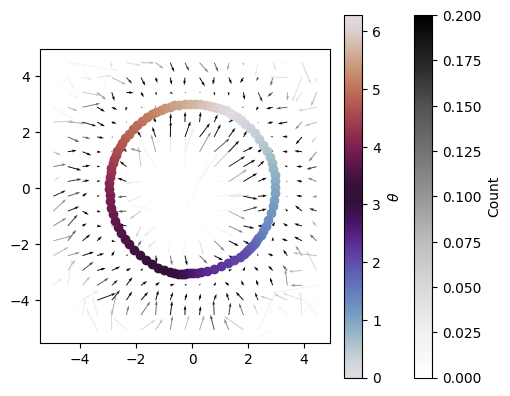

In [30]:
# plot composite dynamics

cmap = plt.cm.twilight
colors = cmap(jnp.linspace(0,2*jnp.pi,len(fixed_points))/(2*jnp.pi))
cmap_count = plt.cm.Greys
norm_count = plt.Normalize(0, 0.2)

fig, ax = plt.subplots(figsize=[5,4], constrained_layout=True);
ax.quiver(
    *jnp.meshgrid(x_bin_edges, y_bin_edges), *composite_Fs,
    bin_counts.T/jnp.amax(bin_counts), cmap=cmap_count, norm=norm_count, 
    scale=20
    )

for i, fp in enumerate(fixed_points):
    ax.scatter(*fp, color=colors[i])
ax.set_aspect('equal')

# Color of quiver is set by count, lighter means less count (thus more uncertain about calculation)
sm_count = plt.cm.ScalarMappable(cmap=cmap_count, norm=norm_count)
cbar_quiver = plt.colorbar(sm_count, ax=ax, orientation='vertical')
cbar_quiver.set_label('Count')

# Add colorbar for scatter
norm = plt.Normalize(0, 2*jnp.pi)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar_scatter = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar_scatter.set_label(r'$\theta$')

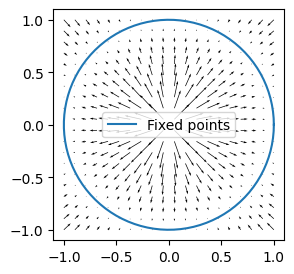

In [22]:
# Non-activity based average, for comparison

def F(x):
    _theta = jnp.arctan2(x[1], x[0]) % (2*jnp.pi)
    _A_theta = A_prior(params.dynamics_gp_weights, jnp.array([_theta])).squeeze()
    _b_theta = b_prior(params.bias_gp_weights,  jnp.array([_theta])).squeeze()
    return (_A_theta - jnp.eye(2)) @ x + _b_theta

# Plot vector field

_x_gridpoints = jnp.linspace(-1, 1, 20)
_y_gridpoints = jnp.linspace(-1, 1, 20)
_X1, _X2 = jnp.meshgrid(_x_gridpoints, _y_gridpoints)
_X = jnp.stack([_X1.ravel(), _X2.ravel()]).T
_F = jax.vmap(lambda x: F(x))(jnp.array(_X))
_F = _F.reshape(len(_x_gridpoints), len(_y_gridpoints), 2).transpose(2, 0, 1)

fig, ax = plt.subplots(figsize=[3,3])
ax.quiver(_X1, _X2, *_F)#, scale=20, width=0.005) 
ax.plot(jnp.cos(jnp.linspace(0, 2*jnp.pi, 100)), jnp.sin(jnp.linspace(0, 2*jnp.pi, 100)), '-', label='Fixed points')
ax.legend()
ax.set_aspect('equal')
# plt.savefig("figures/HD_flowfield_th.eps")